## Import necessary libraries and packages


In [1]:
import pandas as pd
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

2022-04-02 12:52:11.337241: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-02 12:52:11.337285: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Dataset information

In [2]:
medium_data = pd.read_csv('medium_data.csv')
medium_data.head()

,id,url,title,subtitle,image,claps,responses,reading_time,publication,date
0,1,https://towardsdatascience.com/a-beginners-gui...,A Beginner’s Guide to Word Embedding with Gens...,NaN,1.png,850,8,8,Towards Data Science,2019-05-30
1,2,https://towardsdatascience.com/hands-on-graph-...,Hands-on Graph Neural Networks with PyTorch & ...,NaN,2.png,1100,11,9,Towards Data Science,2019-05-30
2,3,https://towardsdatascience.com/how-to-use-ggpl...,How to Use ggplot2 in Python,A Grammar of Graphics for Python,3.png,767,1,5,Towards Data Science,2019-05-30
3,4,https://towardsdatascience.com/databricks-how-...,Databricks: How to Save Files in CSV on Your L...,When I work on Python projects dealing…,4.jpeg,354,0,4,Towards Data Science,2019-05-30
4,5,https://towardsdatascience.com/a-step-by-step-...,A Step-by-Step Implementation of Gradient Desc...,One example of building neural…,5.jpeg,211,3,4,Towards Data Science,2019-05-30


In [3]:
print("Number of records: ", medium_data.shape[0])
print("Number of fields: ", medium_data.shape[1])

Number of records:  6508
Number of fields:  10


Here, we have a 10 different fields and 6508 records but we will only use title field for predicting next word.

## Display titles of various articles and preprocess them

In [4]:
medium_data['title']

0       A Beginner’s Guide to Word Embedding with Gens...
1       Hands-on Graph Neural Networks with PyTorch & ...
2                            How to Use ggplot2 in Python
3       Databricks: How to Save Files in CSV on Your L...
4       A Step-by-Step Implementation of Gradient Desc...
                              ...                        
6503    “We” vs “I” — How Should You Talk About Yourse...
6504                     How Donald Trump Markets Himself
6505        Content and Marketing Beyond Mass Consumption
6506    5 Questions All Copywriters Should Ask Clients...
6507               How To Write a Good Business Blog Post
Name: title, Length: 6508, dtype: object

## Removing unwanted characters and words in titles¶


In [5]:
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace(u'\xa0',u' '))
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace('\u200a',' '))

## Tokenzation

Tokenzaion is the process in which we provide an unique id to all the words and make a word index or we can say vocabulary.

In [6]:
tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
tokenizer.fit_on_texts(medium_data['title'])
total_words = len(tokenizer.word_index) + 1

print("Total number of words: ", total_words)
print("Word: ID")
print("------------")
print("<oov>: ", tokenizer.word_index['<oov>'])
print("Strong: ", tokenizer.word_index['strong'])
print("And: ", tokenizer.word_index['and'])
print("Consumption: ", tokenizer.word_index['consumption'])

Total number of words:  8238
Word: ID
------------
<oov>:  1
Strong:  4
And:  8
Consumption:  8237


Titles text into sequences and make n_gram model
suppose, we have sentence like "I am Yash" and this will convert into a sequence with their respective tokens {'I': 1,'am': 2,'Yash': 3}. Thus, output will be [ '1' ,'2' ,'3' ]

Likewise, our all titles will be converted into sequences.

Then, we will make a n_gram model for good prediction.

Below image explain about everything.

In [13]:
input_sequences = []
for line in medium_data['title']:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)
print("Total input sequences: ", len(input_sequences))

Total input sequences:  48461


In [47]:
input_sequences

[[5, 676],
 [5, 676, 68],
 [5, 676, 68, 2],
 [5, 676, 68, 2, 452],
 [5, 676, 68, 2, 452, 1518],
 [5, 676, 68, 2, 452, 1518, 14],
 [5, 676, 68, 2, 452, 1518, 14, 2455],
 [5, 676, 68, 2, 452, 1518, 14, 2455, 3653],
 [5, 676, 68, 2, 452, 1518, 14, 2455, 3653, 99],
 [1858, 23],
 [1858, 23, 741],
 [1858, 23, 741, 81],
 [1858, 23, 741, 81, 103],
 [1858, 23, 741, 81, 103, 14],
 [1858, 23, 741, 81, 103, 14, 345],
 [1858, 23, 741, 81, 103, 14, 345, 345],
 [1858, 23, 741, 81, 103, 14, 345, 345, 1859],
 [7, 2],
 [7, 2, 67],
 [7, 2, 67, 3654],
 [7, 2, 67, 3654, 9],
 [7, 2, 67, 3654, 9, 40],
 [3655, 7],
 [3655, 7, 2],
 [3655, 7, 2, 266],
 [3655, 7, 2, 266, 1283],
 [3655, 7, 2, 266, 1283, 9],
 [3655, 7, 2, 266, 1283, 9, 2456],
 [3655, 7, 2, 266, 1283, 9, 2456, 23],
 [3655, 7, 2, 266, 1283, 9, 2456, 23, 10],
 [3655, 7, 2, 266, 1283, 9, 2456, 23, 10, 938],
 [3655, 7, 2, 266, 1283, 9, 2456, 23, 10, 938, 222],
 [5, 192],
 [5, 192, 64],
 [5, 192, 64, 192],
 [5, 192, 64, 192, 485],
 [5, 192, 64, 192, 485,

## Make all titles with same length by using padding

The length of every title has to be the same. To make it, we need to find a title that has a maximum length, and based on that length, we have to pad rest of titles.

In [49]:
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   5,
       676], dtype=int32)

## Prepare features and labels

Here, we consider last element of all sequences as a label.Then, We need to perform onehot encoding on labels corresponding to total_words.

In [52]:
# create features and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [64]:
labels

array([676,  68,   2, ...,  56, 730, 550], dtype=int32)

In [67]:
len(ys[0])

8238

Here we can see it has too big sparce matrix

In [57]:
labels.shape

(48461,)

In [58]:
print(xs[5])
print(labels[5])
print(ys[5][14])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    5  676   68    2  452 1518]
14
1.0


## LSTM Neural Network Model training

In [68]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1)) #Input Layer
model.add(LSTM(150))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fiLt(xs, ys, epochs=50, verbose=1)
#print model.summary()
print(model)

2022-04-02 13:33:10.501157: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-02 13:33:10.501359: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-04-02 13:33:10.501526: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-04-02 13:33:10.505541: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-04-02 13:33:10.505637: W tensorflow/stream_executor/platform/default/dso_loader

Epoch 1/50


2022-04-02 13:33:10.890252: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1596886872 exceeds 10% of free system memory.


1515/1515 [==============================] - 103s 66ms/step - loss: 6.7634 - accuracy: 0.1275
Epoch 2/50
1515/1515 [==============================] - 119s 78ms/step - loss: 5.7775 - accuracy: 0.1772
Epoch 3/50
1515/1515 [==============================] - 120s 79ms/step - loss: 4.9452 - accuracy: 0.2043
Epoch 4/50
1515/1515 [==============================] - 119s 79ms/step - loss: 4.2011 - accuracy: 0.2463
Epoch 5/50
1515/1515 [==============================] - 119s 79ms/step - loss: 3.6324 - accuracy: 0.2958
Epoch 6/50
1515/1515 [==============================] - 118s 78ms/step - loss: 3.2691 - accuracy: 0.3381
Epoch 7/50
1515/1515 [==============================] - 120s 79ms/step - loss: 3.0258 - accuracy: 0.3688
Epoch 8/50
1515/1515 [==============================] - 119s 78ms/step - loss: 2.8522 - accuracy: 0.3907
Epoch 9/50
1515/1515 [==============================] - 118s 78ms/step - loss: 2.7278 - accuracy: 0.4090
Epoch 10/50
1515/1515 [==============================] - 120s 79ms

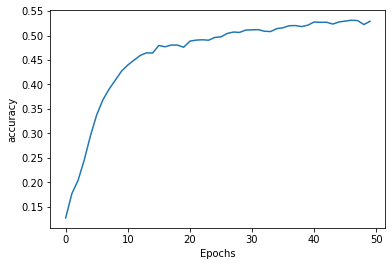

In [70]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()
plot_graphs(history, 'accuracy')

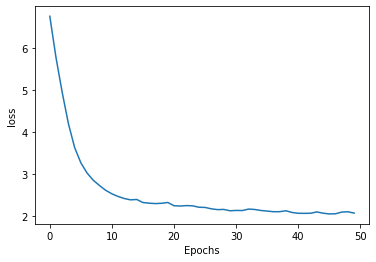

In [71]:
plot_graphs(history, 'loss')

In [86]:
seed_text = "implementation of"
next_words = 2
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted.all():
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

implementation of <oov> <oov>
